In [54]:
import sys
sys.path.append('..')
from swdf.utils import *
convert_uuids_to_indices()
import sklearn
from tsai.basics import *
my_setup(sklearn)
from matplotlib import dates as mdates
import wandb
from fastai.callback.wandb import WandbCallback
from fastai.callback.progress import ShowGraphCallback

os              : Linux-6.8.0-39-generic-x86_64-with-glibc2.31
python          : 3.10.12
tsai            : 0.3.10
fastai          : 2.7.15
fastcore        : 1.5.49
sklearn         : 1.5.1
torch           : 2.2.2+cu121
device          : 1 gpu (['NVIDIA GeForce RTX 3070 Ti Laptop GPU'])
cpu cores       : 14
threads per cpu : 1
RAM             : 15.28 GB
GPU memory      : [8.0] GB


In [55]:
config_base = yaml2dict('./config/base.yaml', attrdict=True)
config_geodstap = yaml2dict('./config/geodstap.yaml', attrdict=True).train
config_tsr = yaml2dict('./config/tsr_decomposition.yaml', attrdict=True)
config_train = config_tsr.train
config_data = config_tsr.data

# Merge the two configs (the second one overrides the first one for any keys that are present in both)
config = AttrDict({**config_base,
                   **config_geodstap,
                   **config_train,
                   "data":AttrDict({**config_data})})

# Add the architecture config
if config.arch_name.lower() == 'patchtst':
    config.arch = yaml2dict('./config/patchtst.yaml', attrdict=True)
else:
    config.arch = AttrDict()

In [56]:
run = wandb.init(project=config.wandb.project, 
                 config=config,
                 group=config.wandb.group,
                 mode=config.wandb.mode, 
                 anonymous='never') if config.wandb.enabled else None
config = dict2attrdict(run.config) if config.wandb.enabled else config

In [57]:
config

```json
{ 'add_time_channels': False,
  'arch': {'attn_dropout': 0.4, 'd_model': 1024, 'dropout': 0.2, 'n_heads': 32},
  'arch_config_file': 'config/patchtst.yaml',
  'arch_name': 'PatchTST',
  'bs': 64,
  'data': { 'data_nb': './geodstap_tsr_data.ipynb',
            'df_save_path': './preprocessed_data/dataframes/geodstap_tsr.pkl',
            'preproc_pipe_save_path': './preprocessed_data/pipelines/preproc_geodstap_tsr.pkl',
            'tsa_model': 'additive'},
  'deltaHL': 4.0,
  'horizon': 48,
  'init_weights': False,
  'is_optuna_study': False,
  'lookback': 144,
  'lr_max': None,
  'n_epoch': 30,
  'partial_n': 0.001,
  'residual_arch': 'PatchTST',
  'season_arch': 'PatchTST',
  'seed': 42,
  'test_end_datetime': '2018-12-31 12:00:00',
  'test_start_datetime': '2012-10-01 12:00:00',
  'trend_arch': 'PatchTST',
  'valid_start_datetime': '2018-01-01 12:00:00',
  'wandb': { 'enabled': False,
             'group': None,
             'log_learner': True,
             'mode': 'offline',
             'project': 'swdf'}}
```

In [58]:
df, preproc_pipe = generate_preprocessed_data(config.data)

df

,Datetime,DST_Trend,DST_Seasonal,DST_Residual,AP_Trend,AP_Seasonal,AP_Residual
0,1957-01-01 00:00:00,-10.215581,-3.938388,26.153969,13.377429,-6.055088,-5.322341
1,1957-01-01 03:00:00,-10.215641,-4.895568,24.411209,13.377415,-5.197928,-5.179487
2,1957-01-01 06:00:00,-10.215700,-3.695611,18.911312,13.377400,-5.197962,-5.179439
3,1957-01-01 09:00:00,-10.215760,-2.881353,8.097114,13.377386,4.516296,4.106318
4,1957-01-01 12:00:00,-10.215819,-4.924216,15.140036,13.377373,6.230586,-4.607958
...,...,...,...,...,...,...,...
197518,2024-08-06 18:00:00,-10.598428,8.379153,-12.080726,7.949211,-2.072029,-0.877182
197519,2024-08-06 21:00:00,-10.598423,4.079117,-12.180696,7.949199,-4.357522,2.408322
197520,2024-08-07 00:00:00,-10.598417,3.336191,-10.037773,7.949188,-3.928775,-0.020412
197521,2024-08-07 03:00:00,-10.598412,8.136136,-13.537724,7.949176,-4.500100,2.550924


# Train

In [41]:
# In the paper by Licata et al. (2020) (https://agupubs.onlinelibrary.wiley.com/doi/pdf/10.1029/2020SW002496),
# authors use a period from October 2012 through the end of 2018 for the benchmarking.
# Therefore, we will set the test set as the same period for our analysis, 
# using the column Date as the timestamp, from October 2012 to the end of 2018. 
# Everything before the test set will be used for training, and everything after the test set
# will be used for validation
test_start_datetime = config.test_start_datetime
test_end_datetime = config.test_end_datetime
valid_start_datetime = config.valid_start_datetime

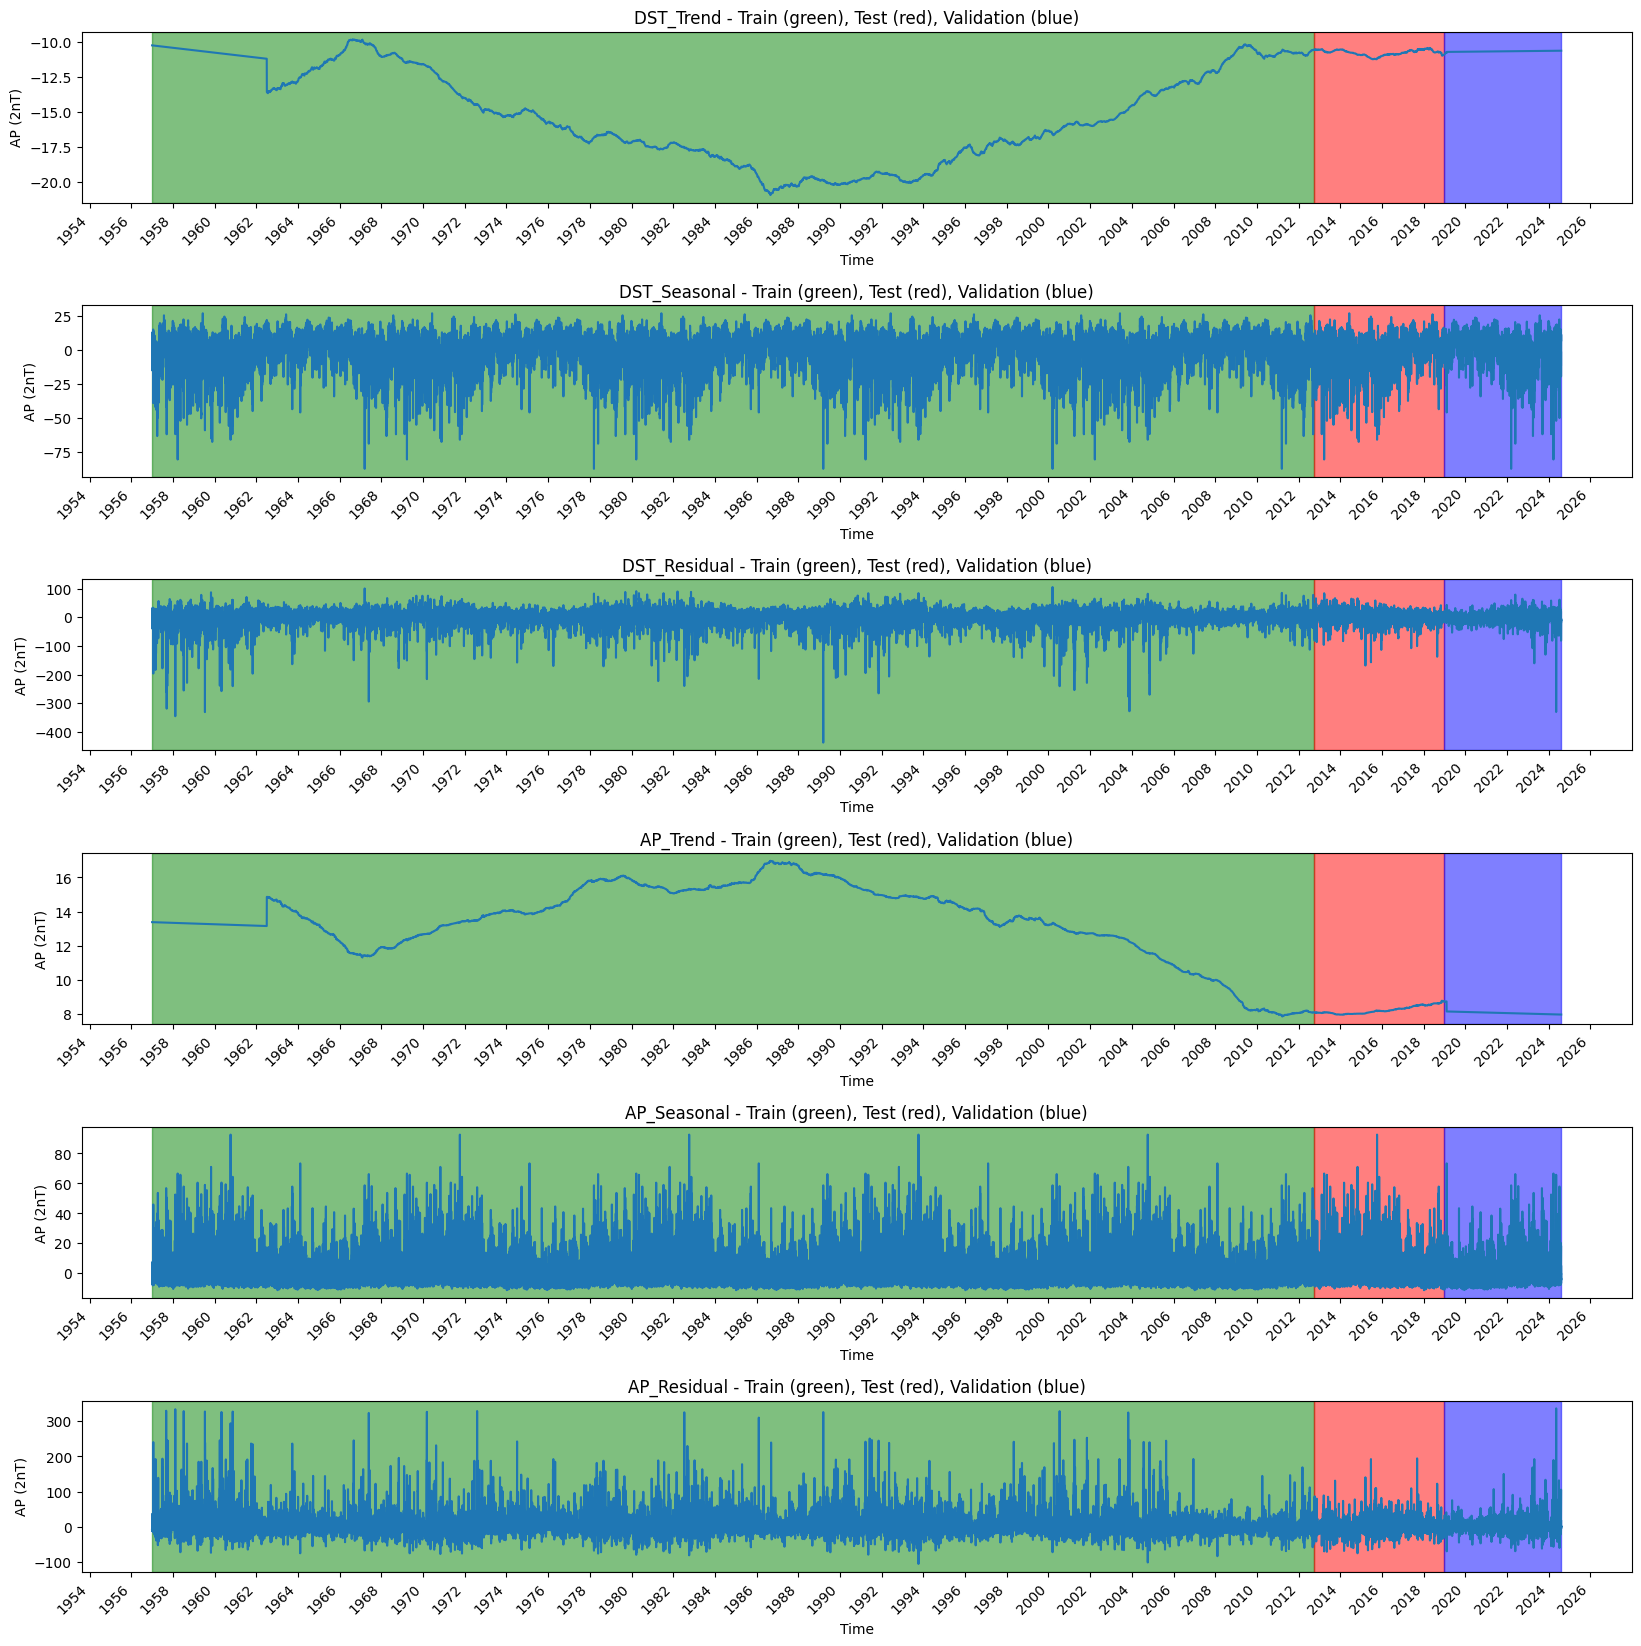

In [42]:
# hide
data_columns = df.columns.drop('Datetime')

fig, ax = plt.subplots(len(data_columns), 1, figsize=(20, 20))
plt.subplots_adjust(hspace=0.6)

for i, value in enumerate(data_columns): 
    ax[i].plot(df.Datetime, df[value])
    ax[i].axvspan(df.Datetime.min(), test_start_datetime, alpha=0.5, color='green')
    ax[i].axvspan(test_start_datetime, test_end_datetime, alpha=0.5, color='red')
    ax[i].axvspan(test_end_datetime, df.Datetime.max(), alpha=0.5, color='blue')
    ax[i].set_title(f'{value} - Train (green), Test (red), Validation (blue)')
    ax[i].set_xlabel('Time')
    ax[i].set_ylabel('AP (2nT)')
    ax[i].xaxis.set_major_locator(mdates.YearLocator(2))
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    ax[i].xaxis.set_major_locator(mdates.YearLocator(2))
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.setp(ax[i].get_xticklabels(), rotation=45, ha="right")
plt.show()

In [43]:
splits_ = get_forecasting_splits(df[df.Datetime < valid_start_datetime], 
                             fcst_history=config.lookback, 
                             fcst_horizon=config.horizon, 
                             use_index=False, 
                             test_cutoff_datetime=test_start_datetime, 
                             show_plot=False, 
                             datetime_col='Datetime')
foo = df[df.Datetime >= valid_start_datetime]
bar = get_forecasting_splits(foo, config.lookback, config.horizon, valid_size=0.0, 
                             test_size=0.0, show_plot=False)
val_idxs = L(foo.index[bar[0]].tolist())

splits = (splits_[0], val_idxs, splits_[1])
splits

((#162710) [0,1,2,3,4,5,6,7,8,9...],
 (#19088) [178244,178245,178246,178247,178248,178249,178250,178251,178252,178253...],
 (#15296) [162757,162758,162759,162760,162761,162762,162763,162764,162765,162766...])

In [44]:
train_split = splits[0]
exp_pipe = sklearn.pipeline.Pipeline([
    ('scaler', TSStandardScaler(columns=data_columns)),
], verbose=True)
df_scaled = exp_pipe.fit_transform(df.copy(), scaler__idxs = train_split)

df_scaled.head()

[Pipeline] ............ (step 1 of 1) Processing scaler, total=   0.0s


,Datetime,DST_Trend,DST_Seasonal,DST_Residual,AP_Trend,AP_Seasonal,AP_Residual
0,1957-01-01 00:00:00,1.432892,-0.373766,1.281788,-0.031004,-0.767432,-0.313722
1,1957-01-01 03:00:00,1.432874,-0.465355,1.198177,-0.031011,-0.659182,-0.305796
2,1957-01-01 06:00:00,1.432856,-0.350536,0.934310,-0.031017,-0.659186,-0.305793
3,1957-01-01 09:00:00,1.432838,-0.272624,0.415481,-0.031024,0.567617,0.209455
4,1957-01-01 12:00:00,1.432821,-0.468096,0.753377,-0.031030,0.784113,-0.274083


In [45]:
save_object(exp_pipe, 'tmp/exp_pipe_tsr_geodstap.pkl')

tmp directory already exists.
Pipeline saved as tmp/exp_pipe_tsr_geodstap.pkl


In [46]:
def prepare_data(condition:str):
    data_columns = [data_column + f"_{condition}" for data_column in ['AP', 'DST']]

    X, y = prepare_forecasting_data(df, fcst_history=config.lookback, 
                                    fcst_horizon=config.horizon,
                                    x_vars=data_columns, 
                                    y_vars=data_columns)
    return X, y 

X_trend, y_trend = prepare_data('Trend')
X_seasonal, y_seasonal = prepare_data('Seasonal')
X_residual, y_residual = prepare_data('Residual')

X_trend.shape, y_trend.shape

((197332, 2, 144), (197332, 2, 48))

In [47]:
from swdf.losses import *

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
wandb_callback = WandbCallback(log_preds=False)
cbs = L(wandb_callback) if config.wandb.enabled else L()

def train(X, y, arch_name, loss, metrics):
    learn = TSForecaster(X, y, splits=splits, batch_size=config.bs,
                        loss_func=loss,
                        metrics=metrics,
                        pipelines=[preproc_pipe, exp_pipe],
                        arch=arch_name, arch_config=config.arch,
                        init=config.init_weights,
                        cbs= cbs + ShowGraphCallback(),
                        partial_n=config.partial_n)

    lr_max = learn.lr_find().valley if config.lr_max is None else config.lr_max

    print(f"#params: {sum(p.numel() for p in learn.model.parameters())}")
    learn.fit_one_cycle(n_epoch=config.n_epoch, lr_max=lr_max)

    return learn

#params: 17720374


epoch,train_loss,valid_loss,Metrics_Not_Available,time
0,0.026285,0.005918,nan,00:05
1,0.025643,0.005553,nan,00:05
2,0.023918,0.004877,nan,00:05
3,0.023710,0.004181,nan,00:05
4,0.022216,0.003801,nan,00:05
5,0.022336,0.003620,nan,00:05
6,0.021075,0.003462,nan,00:05
7,0.020103,0.003455,nan,00:05
8,0.019115,0.003484,nan,00:05
9,0.018369,0.003246,nan,00:05


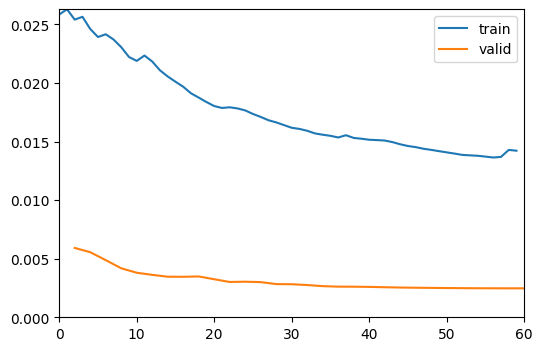

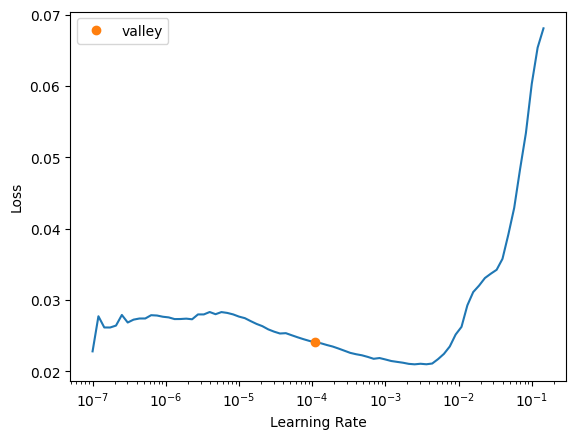

In [48]:
loss = MAELoss(reduction='mean').to(device)
metrics = LossMetrics(loss, []).get_metrics()

learn_trend = train(X_trend, y_trend, config.trend_arch, loss, metrics)

#params: 17720374


epoch,train_loss,valid_loss,Metrics_Not_Available,time
0,3.582514,2.902966,nan,00:06
1,3.559102,2.861700,nan,00:06
2,3.526639,2.801901,nan,00:06
3,3.493352,2.756886,nan,00:06
4,3.408082,2.710191,nan,00:06
5,3.341174,2.664645,nan,00:06
6,3.329657,2.637244,nan,00:06
7,3.300375,2.595853,nan,00:06
8,3.263797,2.548761,nan,00:06
9,3.238819,2.496175,nan,00:06


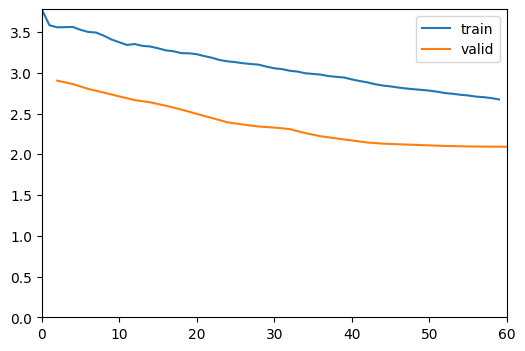

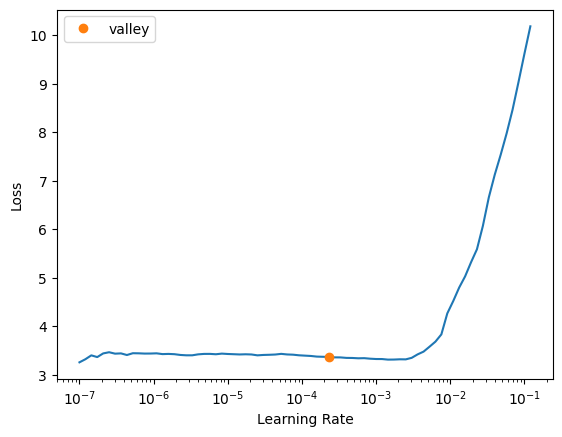

In [49]:
loss = QuantileLoss(reduction='mean', quantile=0.8).to(device)
metrics = LossMetrics(loss, []).get_metrics()

learn_seasonal = train(X_seasonal, y_seasonal, config.season_arch, loss, metrics)

#params: 17720374


epoch,train_loss,valid_loss,Metrics_Not_Available,time
0,7.684733,4.830626,nan,00:06
1,7.724669,4.819808,nan,00:06
2,7.623158,4.785807,nan,00:06
3,7.442454,4.723879,nan,00:06
4,7.354455,4.642175,nan,00:06
5,7.261854,4.557992,nan,00:06
6,7.206007,4.486247,nan,00:06
7,7.152927,4.429691,nan,00:06
8,7.013021,4.371509,nan,00:06
9,6.965860,4.315287,nan,00:06


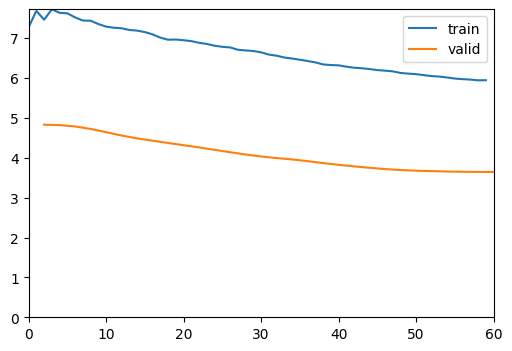

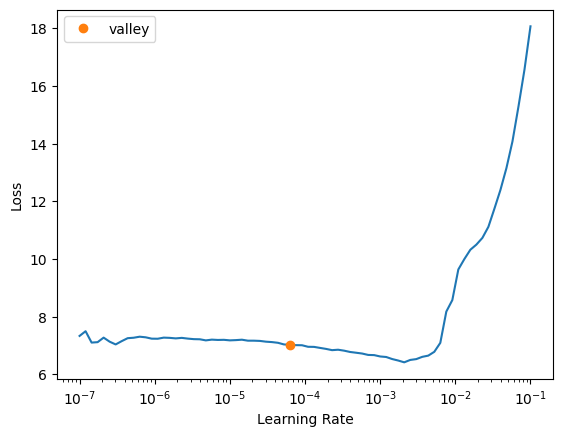

In [50]:
loss = QuantileLoss(reduction='mean', quantile=0.9).to(device)
metrics = LossMetrics(loss, []).get_metrics()

learn_residual = train(X_residual, y_residual, config.residual_arch, loss, metrics)

In [51]:
valid_loss = learn_trend.validate()[0] + learn_seasonal.validate()[0] + learn_residual.validate()[0] 

print(valid_loss)
%store valid_loss

5.740217527374625
Stored 'valid_loss' (float)


In [52]:
# Save everything
learn_trend.dls.loaders += [learn_trend.dls.valid.new_dl(X_trend[splits[2]], y_trend[splits[2]])] 
learn_seasonal.dls.loaders += [learn_seasonal.dls.valid.new_dl(X_seasonal[splits[2]], y_seasonal[splits[2]])] 
learn_residual.dls.loaders += [learn_residual.dls.valid.new_dl(X_residual[splits[2]], y_residual[splits[2]])] 

# Remove the wandb callback to avoid errors when downloading the learner
if config.wandb.enabled:
    learn_trend.remove_cb(wandb_callback)
    learn_seasonal.remove_cb(wandb_callback)
    learn_residual.remove_cb(wandb_callback)

In [53]:
best_valid_loss = np.inf
%store -r best_valid_loss

save_all_or_best = (config.is_optuna_study and valid_loss < best_valid_loss) or not config.is_optuna_study

if save_all_or_best:
    best_valid_loss = valid_loss
    %store best_valid_loss                                             

    # Save locally and in wandb if online and enabled
    learn_trend.save_all(path='tmp', verbose=True, model_fname='model_dstap_trend', learner_fname="learner_dstap_trend") 
    learn_seasonal.save_all(path='tmp', verbose=True, model_fname='model_dstap_seasonal', learner_fname="learner_dstap_seasonal") 
    learn_residual.save_all(path='tmp', verbose=True, model_fname='model_dstap_residual', learner_fname="learner_dstap_residual") 

    if run is not None and config.wandb_mode and config.wandb_log_learner:
        # Save the learner (all tmp/dls, tmp/model.pth, and tmp/learner.pkl). 
        run.log_artifact('tmp', type='learner', name='geodestap_tsr')

    model = {}
    model['models'] = {
                    'Trend':learn_trend.model, 
                    'Seasonal': learn_seasonal.model, 
                    'Residual': learn_residual.model
                    }
    model['lookback'] = config.lookback
    model['horizon'] = config.horizon
    model['data_columns'] = ['AP', 'DST']
    model['components'] = ['Trend', 'Seasonal', 'Residual']

    torch.save(model, 'models/best/best_model_tsr_geodstap.pth')

Stored 'best_valid_loss' (float)
Learner saved:
path          = 'tmp'
dls_fname     = '['dls_0.pth', 'dls_1.pth', 'dls_2.pth', 'dls_3.pth']'
model_fname   = 'model_dstap_trend.pth'
learner_fname = 'learner_dstap_trend.pkl'
Learner saved:
path          = 'tmp'
dls_fname     = '['dls_0.pth', 'dls_1.pth', 'dls_2.pth', 'dls_3.pth']'
model_fname   = 'model_dstap_seasonal.pth'
learner_fname = 'learner_dstap_seasonal.pkl'
Learner saved:
path          = 'tmp'
dls_fname     = '['dls_0.pth', 'dls_1.pth', 'dls_2.pth', 'dls_3.pth']'
model_fname   = 'model_dstap_residual.pth'
learner_fname = 'learner_dstap_residual.pkl'
